# Evaluation

- 테스트 데이터셋: BIDMC
- 동일한 전처리 과정(`20_preprocessing.ipynb`)을 거쳐서 데이터를 뽑은 다음 이를 이용해서 데이터 결과를 확인한다.

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
%matplotlib inline
plt.style.use('ggplot')

In [2]:
DATA_PATH = '../../DataLake/bidmc_csv'
regex = re.compile('bidmc_[0-9]+')

In [3]:
bidmc_id = sorted(list(set([regex.match(filename.name).group() for filename in os.scandir(DATA_PATH)])))

In [4]:
pleth = pd.read_csv(f'{DATA_PATH}/{bidmc_id[0]}_Signals.csv', usecols=['Time [s]', ' PLETH'])
resp = pd.read_csv(f'{DATA_PATH}/{bidmc_id[0]}_Numerics.csv', usecols=['Time [s]', ' RESP'])

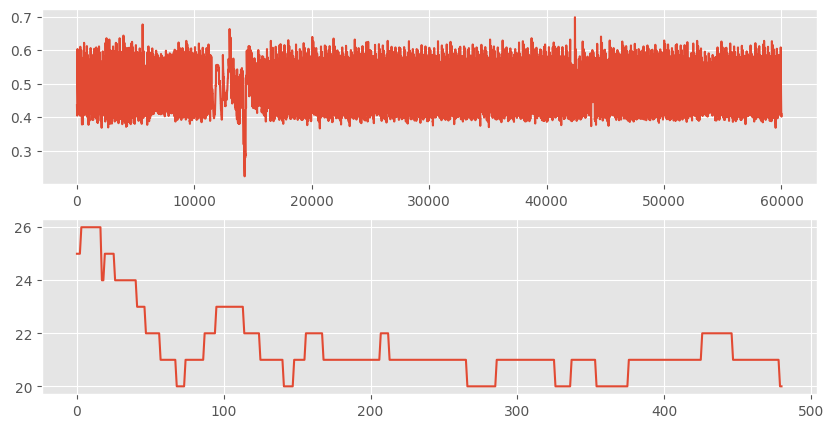

In [5]:
fig, axs = plt.subplots(2,1,figsize=(10,5))
axs[0].plot(pleth[' PLETH'].values)
axs[1].plot(resp[' RESP'].values)
plt.show()

In [6]:
pleths = [pd.read_csv(f'{DATA_PATH}/{sid}_Signals.csv', usecols=['Time [s]', ' PLETH'])[' PLETH'].values for sid in bidmc_id]
resps = [pd.read_csv(f'{DATA_PATH}/{sid}_Numerics.csv', usecols=['Time [s]', ' RESP'])[' RESP'].values for sid in bidmc_id]
print(len(pleths), len(resps))
print(len(pleths[0]), len(resps[0]))

53 53
60001 481


## 1. Filtering

In [7]:
import multiprocessing
from scipy import signal

In [8]:
taps = signal.firwin(numtaps=400, cutoff=[0.5, 8.0], window='hamming', pass_zero=False, fs=125)
w, h = signal.freqz(taps)

In [11]:
pool = multiprocessing.Pool(processes=40)
filtered_pleths = np.asarray(pool.starmap(signal.filtfilt, [(taps, 1.0, pleth) for pleth in pleths]))
pool.close()
pool.join()

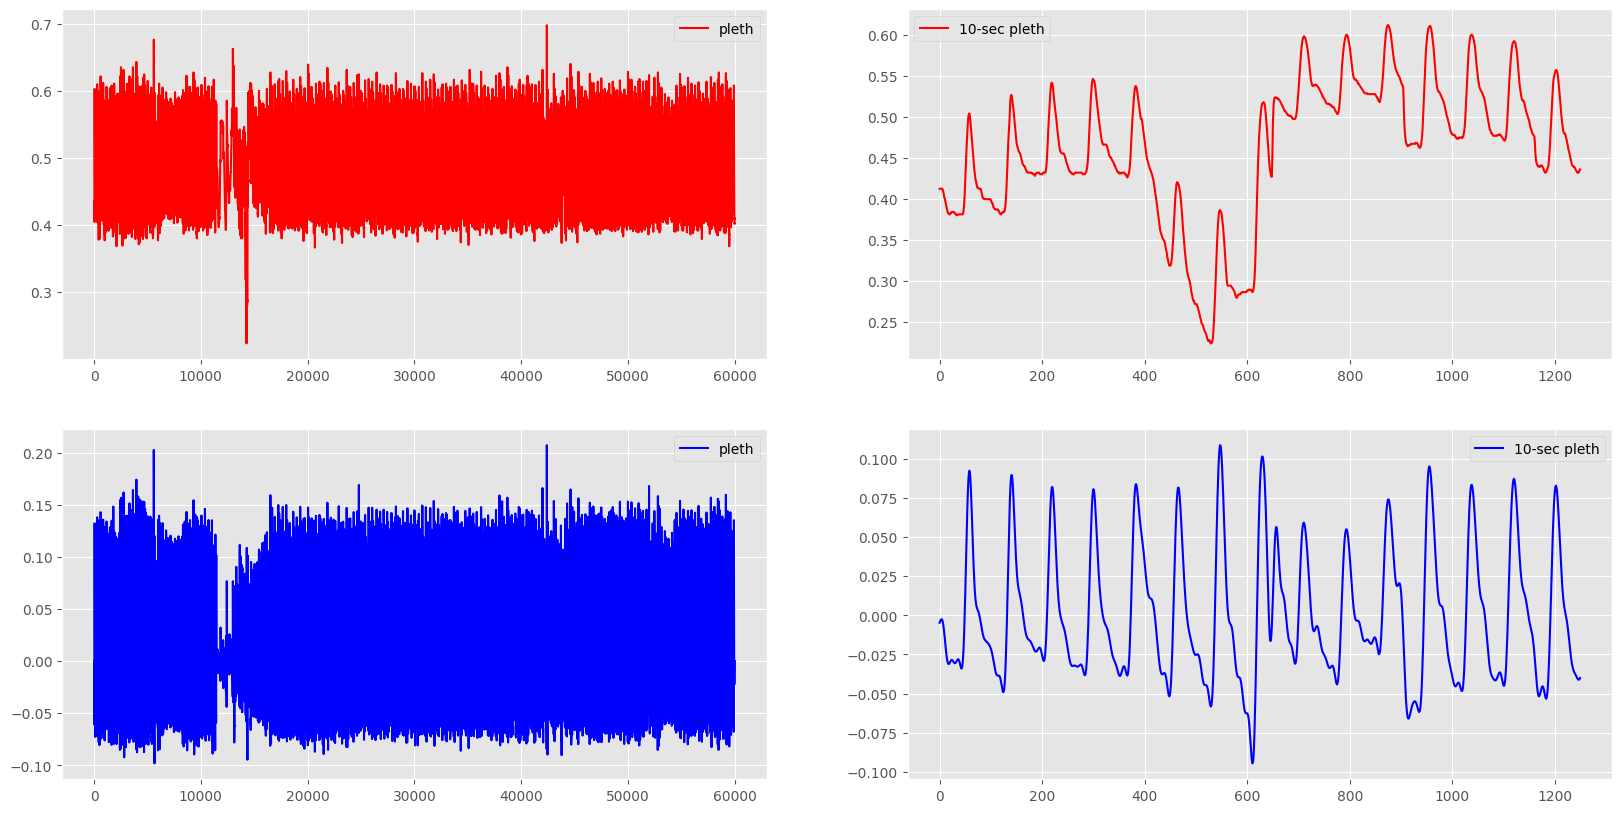

In [12]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
axs[0][0].plot(pleths[0], label='pleth', color='r')
axs[0][0].legend()
axs[0][1].plot(pleths[0][125*110:125*120], label='10-sec pleth', color='r')
axs[0][1].legend()
axs[1][0].plot(filtered_pleths[0], label='pleth', color='b')
axs[1][0].legend()
axs[1][1].plot(filtered_pleths[0][125*110:125*120], label='10-sec pleth', color='b')
axs[1][1].legend()
plt.show()

## 2. SMA RR signal (Need to discuss)

기존의 BIDMC의 Resp는 초당 데이터로 기록되어 있다.

이를 분당 데이터로 라벨링 하기 위해서 60초 윈도우를 생성하고 그때의 평균값을 구한다. 이를 위해서 이동평균을 적용한다.

이동평균은 한 샘플씩 이동하므로 1초씩 이동하는 것이다. 

PLETH 입장에서 이는 125개 샘플씩 이동하는 것이므로 Window의 shifting 할 때 이를 반영하면 된다.

그러므로 PLETH는 125개 샘플(1초)씩 shift.

RESP는 1개 샘플(1초)씩 shift.

> 다만 고민인 것은 이동평균이 적용된 호흡수를 정답으로 사용할 것인데 한 차례 분당호흡수로 가공된 데이터를 라벨로 사용해도 괜찮을지이다.

In [16]:
from itertools import starmap

def sma(xn, w):
    return np.convolve(xn, np.ones(w), 'valid') / w

In [17]:
sma_resps = np.asarray(list(starmap(sma, [(resp, 60) for resp in resps])))
print(len(sma_resps), len(sma_resps[0]))

53 422


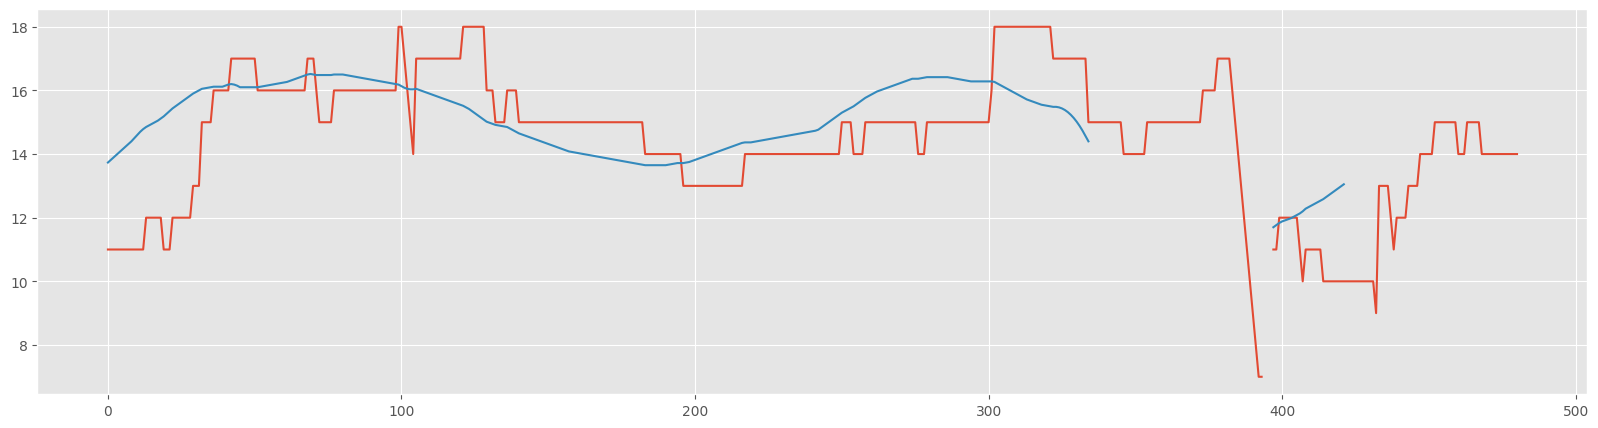

In [18]:
plt.figure(figsize=(20,5))
plt.plot(resps[14])
plt.plot(sma_resps[14])
plt.show()

### Not a Number 제거

In [21]:
useless = np.where(np.asarray([np.isnan(sma_resps[i]).any() for i in range(len(sma_resps))])==True)[0]
print(useless)

[12 14 18]


In [22]:
filt_sma_resps = np.delete(sma_resps, useless, axis=0)
filtered_pleths2 = np.delete(filtered_pleths, useless, axis=0)
filt_sma_resps.shape, filtered_pleths2.shape

((50, 422), (50, 60001))

In [23]:
np.isnan(filtered_pleths2).any(), np.isnan(filt_sma_resps).any()

(False, False)

## 3. Windowing

`sma_resps` 가 기준이 되어야 한다.

In [24]:
fs = 125
window_size = fs * 60
shift = int(window_size/60) # 125
N = len(filtered_pleths2)

In [25]:
dataset = []
for j in range(N):
    for i, resp in enumerate(filt_sma_resps[j]):
        temp = []
        temp.append(filtered_pleths2[j][0+(shift*i):window_size+(shift*i)])
        temp.append(resp)
        dataset.append(temp)

len(dataset)

21100

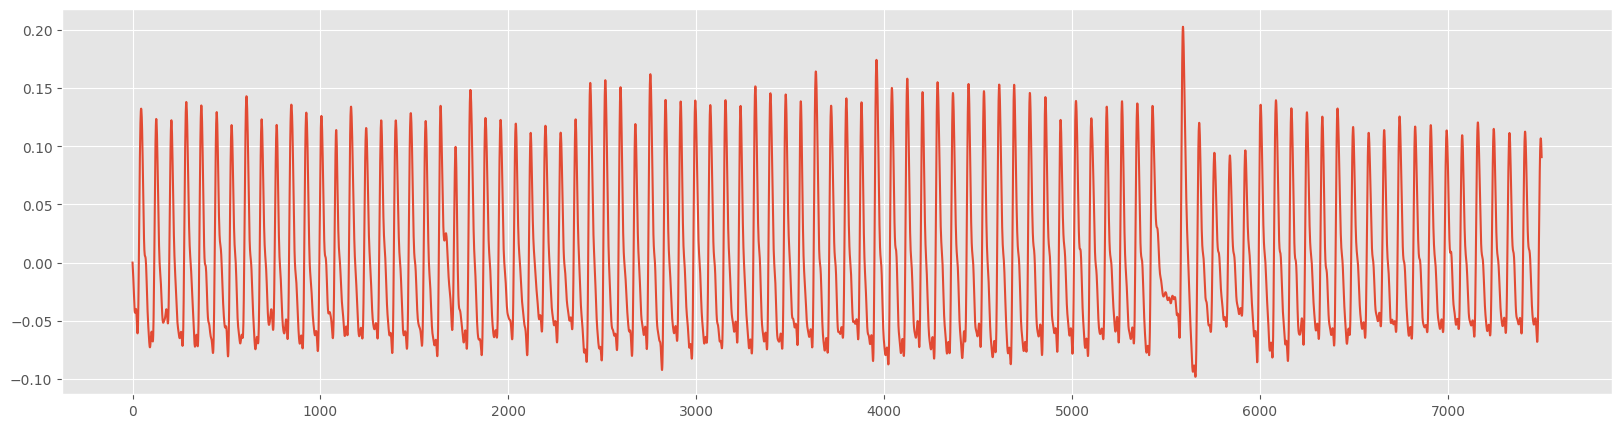

In [26]:
plt.figure(figsize=(20,5))
plt.plot(dataset[0][0])
plt.show()

In [28]:
filt_dataset = list(filter(lambda x: len(x[0])==7500, dataset))
len(filt_dataset) # 22366 - 53

21050

In [29]:
len(list(filter(lambda x: np.isnan(x[1]), dataset)))

0

## (option) Resampling

In [30]:
def interpolation(x, input):
    x0 = int(np.floor(x))
    y0 = input[x0]
    x1 = int(np.ceil(x))
    y1 = input[x1]
    y = (y1-y0)*(x-x0) + y0
    return y


def signal_resample(input_signal, org_fs, new_fs, method='interpolation'):
    output_signal = []
    new_x = np.arange(0, len(input_signal), org_fs/new_fs)
    
    if method == 'interpolation': 
        interp = interpolation

    for x in new_x:
        y = interp(x, input_signal)
        output_signal.append(y)

    return np.asarray(output_signal)

In [31]:
pool = multiprocessing.Pool(processes=40)
result = pool.starmap(signal_resample, [(pleth[0], 125, 30) for pleth in filt_dataset])
pool.close()
pool.join()

In [32]:
new_dataset = []
for i in range(len(filt_dataset)):
    temp = []
    temp.append(result[i])
    temp.append(filt_dataset[i][1])
    new_dataset.append(temp)

len(new_dataset)

21050

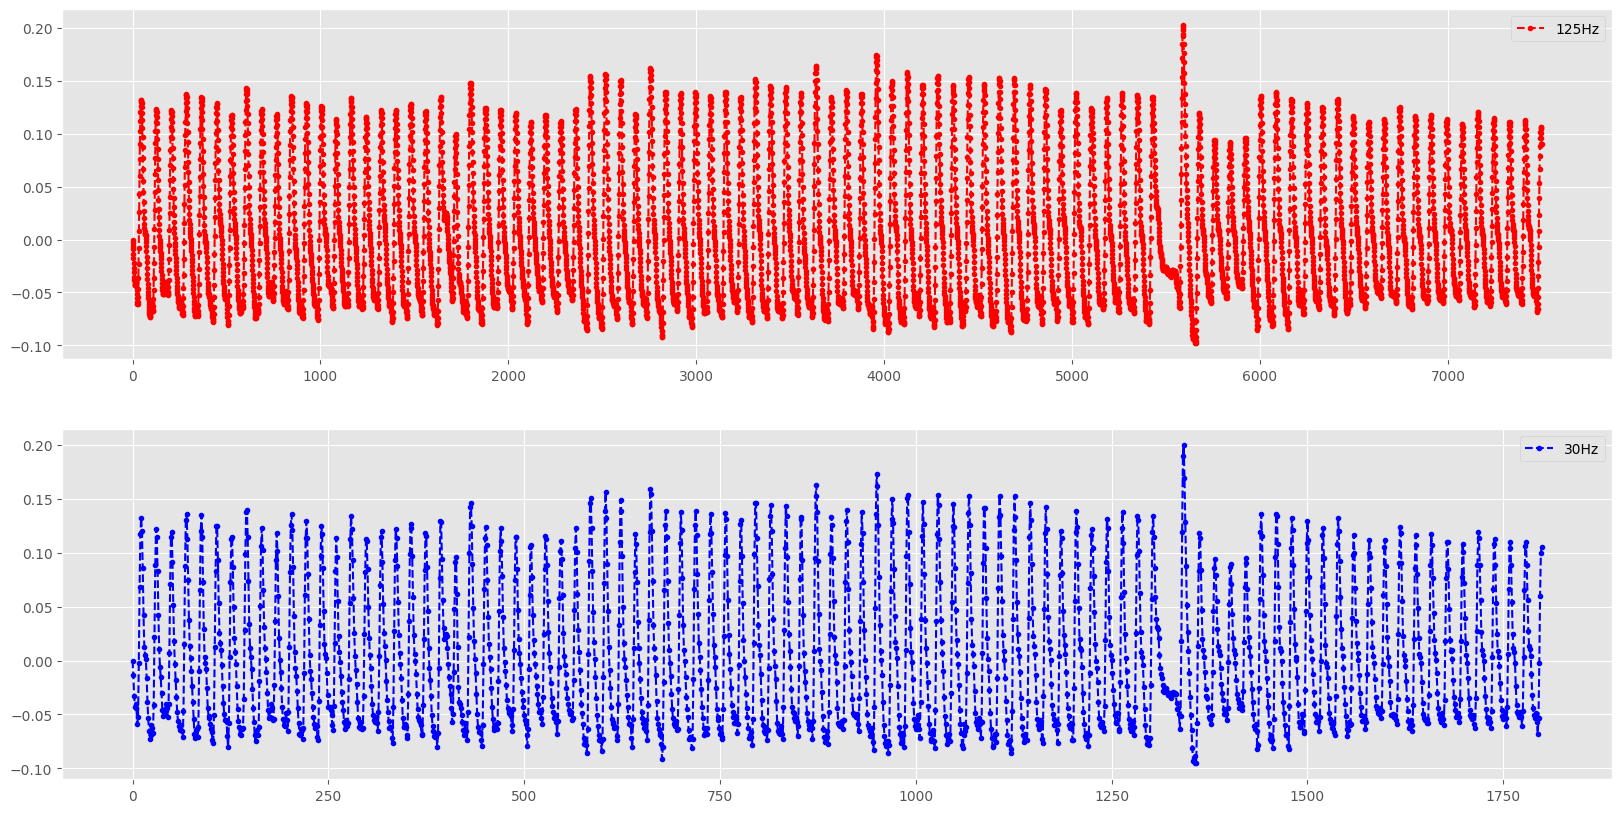

In [33]:
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(filt_dataset[0][0], linestyle='--', marker='o', markersize=3, color='r', label='125Hz')
axs[0].legend()
axs[1].plot(new_dataset[0][0], linestyle='--', marker='o', markersize=3, color='b', label='30Hz')
axs[1].legend()
plt.show()

In [34]:
import gzip
import pickle

In [35]:
with gzip.open(f'../../DataWarehouse/bidmc_RRpo/40_230522_resamp_sliced125_filt_patient_bidmc.pickle.gzip', 'wb') as f:
    pickle.dump(new_dataset, f)